Predictions
===========

We can now create our final script to process an input image:
- take an image as input
- detect what's on the image
    - use Human detector (opencv)
    - use Pokemon detector (pytorch model)
- use the trained Pokemon classifier to give the name of the Pokémon (if it's a Pokémon), 
or the Pokémon it looks like (if it's a Human or something else)

In [1]:
from datetime import datetime

import matplotlib.image as mpimg
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms

In [2]:
import utils
import conf

In [3]:
device = torch.device("cpu")
data_dir='data/Pokemon'

In [4]:
def torch_transformations():
    mean_nums = [0.485, 0.456, 0.406]
    std_nums = [0.229, 0.224, 0.225]

    transform = {'train': transforms.Compose([
        transforms.Resize(size=300),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=256),
        transforms.RandomPerspective(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)

    ]), 'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)

    ]), 'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    }
    return transform, std_nums, mean_nums

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    #validation step
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    #validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.net = models.resnet50(pretrained=True)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Linear(num_ftrs, 150)
        
    def forward(self, xb):
        return self.net(xb)


net = Net()

In [5]:
transform, _,_  = torch_transformations()

import torch.nn as nn
import torch.nn.functional as F

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = transform['test'](image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

In [18]:
def predict(model_path, image_path, classes):
    #net = Net()
    #net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_path, map_location=torch.device('cpu')).items()})
    net = torch.load(model_path, map_location=torch.device('cpu'))
    net.to(device)
    image = image_loader(image_path)
    output = net(image)
    index = output.data.cpu().numpy().argmax()
    return classes[index]

In [20]:
net_aa = torch.load('./classifier_05_epoch_full.pth', map_location=torch.device('cpu'))

In [21]:
torch.save(net_aa.state_dict(), 'classifier_05_epoch_dict.pth')

In [19]:
predict('./classifier_05_epoch_full.pth', '../data/Pokemon/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg', conf.pokemons)

'Rattata'

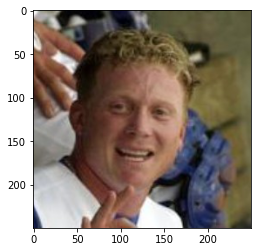

It's a Human, it looks like the Pokemon Blastoise !
Took 0:00:00.202679 to predict


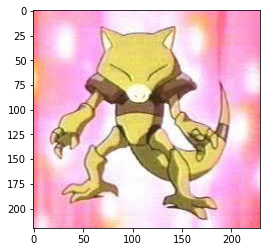

It doesn't look like a Pokemon nor a Human, but it looks like Rattata !
Took 0:00:00.220836 to predict


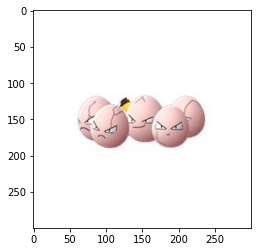

It's a Human, it looks like the Pokemon Exeggcute !
Took 0:00:00.274708 to predict


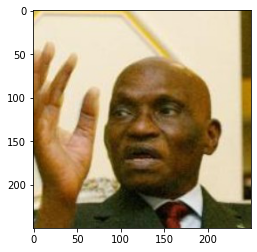

It's a Human, it looks like the Pokemon Pidgeot !
Took 0:00:00.309213 to predict


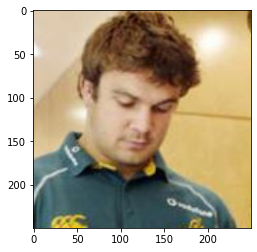

It's a Human, it looks like the Pokemon Tauros !
Took 0:00:00.281719 to predict


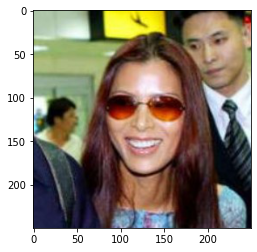

It's a Human, it looks like the Pokemon Exeggutor !
Took 0:00:00.230931 to predict


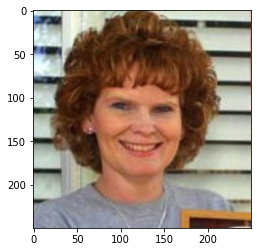

It's a Human, it looks like the Pokemon Drowzee !
Took 0:00:00.221947 to predict


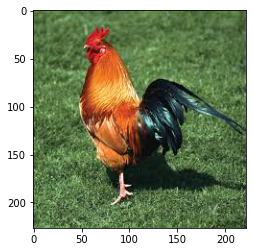

It doesn't look like a Pokemon nor a Human, but it looks like Spearow !
Took 0:00:00.227700 to predict


In [19]:
def human_detector(image_path):
    return utils.face_detector(image_path)

def detect_pokemon(image_path):
    return predict('pokemon_detector.pth', image_path, conf.detector_classes)

def pokemon_classifier(image_path):
    return predict('classifier_05_epoch_full.pth', image_path, conf.pokemons)

def pokemon_identificator(image_path):
    img = mpimg.imread(image_path)
    utils.imshow(img)
    
    start = datetime.now()
    res_detector = detect_pokemon(image_path)
    res_classifier = pokemon_classifier(image_path)
    
    if utils.face_detector(image_path):
        print(f'It\'s a Human, it looks like the Pokemon {res_classifier} !')
    elif res_detector == 'Pokemon':
        print(f'It\'s a Pokemon: {res_classifier} !')
    else:
        print(f'It doesn\'t look like a Pokemon nor a Human, but it looks like {res_classifier} !')

    print(f'Took {datetime.now() - start} to predict')

pokemon_identificator('../data/lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg')
pokemon_identificator('../data/Pokemon/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg')
pokemon_identificator('../data/Pokemon/Exeggcute/58983b10ed8e423a9c42473ae0157745.jpg')
pokemon_identificator('../data/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg')
pokemon_identificator('../data/lfw/Adam_Freier/Adam_Freier_0001.jpg')
pokemon_identificator('../data/lfw/Park_Na-kyong/Park_Na-kyong_0001.jpg')
pokemon_identificator('../data/lfw/Pat_Wharton/Pat_Wharton_0001.jpg')
pokemon_identificator('../chicken.jpeg')